# Cis Effects Template

NOTE: This notebook only looks at cis-effects for events on a single arm. If you're looking at different arm-level events on both arms of a chromosome, then make one copy of this template for the p arm, and another copy for the q arm.

This notebook compares the transcriptomics and proteomics correlations to CNV for cis proteins.

## Setup

In [1]:
import cnvutils
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from scipy import stats
import seaborn as sns
import statsmodels.stats.multitest

In [2]:
# Load parameters
gen_params = cnvutils.load_params(os.path.join("..", "..", "..", "data", "gen_params.json"))
PANCAN = gen_params["PANCAN"]

chr_params = cnvutils.load_params(os.path.join("..", "..", "data", "chr_params.json"))
CHROMOSOME = chr_params["CHROMOSOME"]

arm_params = cnvutils.load_params(os.path.join("..", "data", "arm_params.json"))
ARM = arm_params["ARM"]
CANCER_TYPES = arm_params["ARM_CANCER_TYPES"]
EVENT_START = arm_params["START"]
EVENT_END = arm_params["END"]

# Set cis or trans
CIS_OR_TRANS = "cis"

# Get data tables
data_types = ["CNV", "proteomics", "transcriptomics"]
tables = cnvutils.load_tables(CANCER_TYPES, data_types, pancan=PANCAN)

cnv = tables["CNV"]
proteomics = tables["proteomics"]
transcriptomics = tables["transcriptomics"]

## Load all the data

In [3]:
# Get just the genes that are in our event
genes = cnvutils.get_event_genes(
    chrm=CHROMOSOME,
    event_start=EVENT_START,
    event_end=EVENT_END,
    cis_or_trans=CIS_OR_TRANS
)["Name"].\
drop_duplicates(keep="first")

## Run Pearson Tests

In [4]:
def run_pearsons(protein, cnv_df, omics):
    try:
        if protein in cnv_df.columns.get_level_values('Name'):
            cnv_data = cnv_df.loc[:,cnv_df.columns.get_level_values('Name')==protein]
            cnv_column_name = cnv_data.columns.tolist()[0]
        else:
            return (np.nan, np.nan)
        omics_data = omics[protein]
        if isinstance(omics_data, pd.DataFrame):
            omics_data = omics.iloc[:,0]
        omics_data.name = 'omics'
        df = pd.concat([cnv_data, omics_data], axis=1)
        df.dropna(inplace=True)
        if len(df) < 3:
            return (np.nan,np.nan)
        return stats.pearsonr(df[cnv_column_name], df['omics'])
    except Exception as e:
        print(e)

### Proteomics

In [5]:
proteomics_results = None
for cancer_type in proteomics.keys():
    try:
        # We will use the index from the proteomics table. 
        proteomics_table = proteomics[cancer_type].copy()
        proteomics_table = proteomics_table.loc[:, proteomics_table.columns.get_level_values('Name').isin(genes)]
        if isinstance(proteomics_table.columns, pd.MultiIndex):
            proteomics_table = proteomics_table.droplevel('Database_ID', axis=1)
        pvalues = list()
        rvalues = list()
        index = proteomics_table.columns.get_level_values('Name').tolist()
        for protein in index:
            r, p = run_pearsons(protein, cnv[cancer_type], proteomics_table)
            pvalues.append(p)
            rvalues.append(r)
        # Correct for multiple tests
        pvalues = np.array(pvalues)
        mask = np.isfinite(pvalues)
        pval_corrected = np.empty(len(pvalues))
        pval_corrected.fill(np.nan)
        pval_corrected[mask] = statsmodels.stats.multitest.multipletests(pvals=list(pvalues[mask]), alpha=0.05, method='fdr_bh')[1]
        temp = pd.DataFrame(data={f'{cancer_type}_pvalue_proteomics': pval_corrected, f'{cancer_type}_rvalue_proteomics': rvalues}, index=index)
        temp.index.name = 'Name'
        if proteomics_results is not None:
            proteomics_results = proteomics_results.join(temp, how='outer')
        else:
            proteomics_results = temp
    except Exception as e:
        print(e)

In [6]:
proteomics_results

,brca_pvalue_proteomics,brca_rvalue_proteomics,colon_pvalue_proteomics,colon_rvalue_proteomics,hnscc_pvalue_proteomics,hnscc_rvalue_proteomics,lscc_pvalue_proteomics,lscc_rvalue_proteomics,luad_pvalue_proteomics,luad_rvalue_proteomics,ovarian_pvalue_proteomics,ovarian_rvalue_proteomics
Name,,,,,,,,,,,,
ADAM28,NaN,NaN,NaN,NaN,2.108132e-01,0.177958,1.478738e-03,0.384724,1.282607e-01,0.181190,8.042754e-01,0.096571
ADAMDEC1,4.819245e-01,0.087070,3.953637e-01,0.112317,8.282376e-01,0.043884,8.800121e-01,0.018812,4.062602e-01,0.147031,8.990185e-01,0.034902
AGPAT5,1.202007e-05,0.413724,1.439541e-05,0.458805,7.807306e-07,0.487085,7.015062e-07,0.485135,1.381511e-05,0.427622,1.168256e-06,0.554238
ANGPT2,3.452596e-01,-0.117660,NaN,NaN,2.254744e-01,-0.171935,5.212145e-01,-0.070234,5.601478e-01,0.060401,1.028454e-01,0.375279
ARHGEF10,1.020483e-04,0.371932,6.914934e-02,0.338850,3.751027e-05,0.413378,9.259885e-03,0.268300,1.472338e-05,0.425873,3.279611e-05,0.483415
ASAH1,3.075520e-01,0.113996,9.749984e-04,0.359209,4.679481e-02,0.222722,2.935865e-01,0.117033,2.008727e-02,0.240366,4.777371e-05,0.474588
ATP6V1B2,7.870281e-08,0.499442,1.686621e-10,0.620143,1.004454e-04,0.393477,2.488476e-09,0.563342,2.755257e-05,0.413558,4.332626e-06,0.526577
BIN3,4.212688e-01,0.093540,1.110763e-01,0.192149,1.800322e-01,0.156110,3.615193e-01,0.102610,1.221154e-02,0.258241,2.899884e-04,0.430885
BLK,1.764333e-01,-0.145204,NaN,NaN,3.889869e-01,-0.202301,NaN,NaN,2.184366e-02,0.259306,7.999505e-01,-0.052979


### Transcriptomics

In [7]:
transcriptomics_results = None
for cancer_type in transcriptomics.keys():
    try:
        # We will use the index from the proteomics table. 
        transcriptomics_table = transcriptomics[cancer_type].copy()
        transcriptomics_table = transcriptomics_table.loc[:, transcriptomics_table.columns.get_level_values('Name').isin(genes)]
        if isinstance(transcriptomics_table.columns, pd.MultiIndex):
            transcriptomics_table = transcriptomics_table.droplevel('Database_ID', axis=1)
        pvalues = list()
        rvalues = list()
        index = transcriptomics_table.columns.get_level_values('Name').tolist()
        for protein in index:
            r, p = run_pearsons(protein, cnv[cancer_type], transcriptomics_table)
            pvalues.append(p)
            rvalues.append(r)
        pvalues = np.array(pvalues)
        mask = np.isfinite(pvalues)
        pval_corrected = np.empty(len(pvalues))
        pval_corrected.fill(np.nan)
        pval_corrected[mask] = statsmodels.stats.multitest.multipletests(pvals=list(pvalues[mask]), alpha=0.05, method='fdr_bh')[1]
        temp = pd.DataFrame(data={f'{cancer_type}_pvalue_transcriptomics': pval_corrected, f'{cancer_type}_rvalue_transcriptomics': rvalues}, index=index)
        temp.index.name = 'Name'
        if transcriptomics_results is not None:
            transcriptomics_results = transcriptomics_results.join(temp, how='outer')
        else:
            transcriptomics_results = temp
    except Exception as e:
        print(e)

/home/caleb/anaconda3/envs/dev/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [8]:
transcriptomics_results

,brca_pvalue_transcriptomics,brca_rvalue_transcriptomics,colon_pvalue_transcriptomics,colon_rvalue_transcriptomics,hnscc_pvalue_transcriptomics,hnscc_rvalue_transcriptomics,lscc_pvalue_transcriptomics,lscc_rvalue_transcriptomics,luad_pvalue_transcriptomics,luad_rvalue_transcriptomics,ovarian_pvalue_transcriptomics,ovarian_rvalue_transcriptomics
Name,,,,,,,,,,,,
ADAM28,8.050655e-01,0.036721,1.404796e-03,0.315575,2.418013e-03,0.316978,1.206178e-06,0.462003,6.711553e-05,0.385313,9.135737e-03,0.280817
ADAM7,7.503227e-01,-0.177788,NaN,NaN,1.253782e-02,0.266969,NaN,NaN,2.749602e-01,0.155861,4.195149e-01,0.090221
ADAMDEC1,8.463074e-01,-0.027337,4.408463e-01,0.080675,5.393995e-01,-0.076315,1.021470e-03,0.324688,1.836345e-01,0.133510,3.985229e-01,-0.094751
ADRA1A,7.137210e-01,-0.062427,NaN,NaN,7.887983e-02,0.197855,1.913287e-02,0.241025,5.624217e-02,0.193623,8.319262e-01,-0.023195
AGPAT5,2.063380e-11,0.582839,4.450837e-15,0.681015,8.712121e-09,0.541940,3.335893e-07,0.482015,1.146512e-09,0.555235,1.618649e-10,0.605721
ANGPT2,2.899869e-01,0.122966,1.268716e-01,0.157427,1.147373e-01,0.180657,2.686642e-01,0.112071,6.240303e-04,0.335415,3.565526e-01,0.105211
ARHGEF10,3.979020e-07,0.460846,1.613543e-03,0.311672,9.483451e-04,0.341570,7.316543e-05,0.386414,1.912638e-06,0.451284,1.008726e-05,0.445733
ASAH1,1.664472e-03,0.305205,8.721122e-11,0.588519,1.801105e-06,0.465118,7.780631e-11,0.589132,1.898772e-06,0.451644,3.897319e-13,0.666710
ATP6V1B2,6.744320e-08,0.487665,2.202688e-18,0.735707,7.196257e-13,0.641970,9.626322e-17,0.706147,3.072733e-06,0.443411,1.670321e-10,0.604863


## Create Graphs

In [9]:
# Join the graphs
all_results = transcriptomics_results.join(proteomics_results)

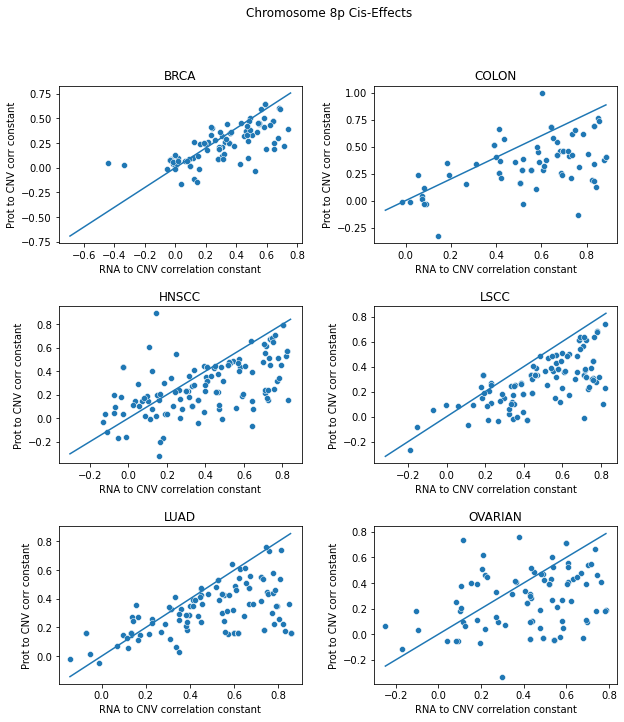

In [10]:
fig, axs = plt.subplots(nrows=3, ncols=2, sharex=False, sharey=False, figsize=(10,11))
fig.suptitle("Chromosome 8p Cis-Effects")
count = 0
for cancer_type in proteomics.keys():
    sns.scatterplot(x=f'{cancer_type}_rvalue_transcriptomics', y=f'{cancer_type}_rvalue_proteomics', data=all_results, ax=axs[count//2][count%2])
    axs[count//2][count%2].set_title(cancer_type.upper())
    axs[count//2][count%2].set_xlabel("RNA to CNV correlation constant")
    axs[count//2][count%2].set_ylabel("Prot to CNV corr constant")
    min_val = np.min(all_results[f'{cancer_type}_rvalue_transcriptomics'])
    max_val = np.max(all_results[f'{cancer_type}_rvalue_transcriptomics'])
    axs[count//2][count%2].plot([min_val,max_val], [min_val,max_val])
    count += 1
plt.subplots_adjust(hspace=0.4, wspace=0.3)

In [11]:
# Save the chart
chart_fmt = gen_params["CHART_FORMAT"]
chart_dpi = gen_params["CHART_DPI"]

chart_dir = os.path.join("..", "data", "charts_img")
chart_path = os.path.join(
    chart_dir,
    f"chr{CHROMOSOME}{ARM}_{CIS_OR_TRANS}_00_pearson_{'harmonized' if PANCAN else 'AWG'}_matplotlib.{chart_fmt}"
)

fig.savefig(chart_path, dpi=chart_dpi)

## Reformat results and save

In [12]:
all_results = transcriptomics_results.join(proteomics_results).reset_index(drop=False)
all_results = all_results.melt(id_vars=['Name'])
all_results[['cancer', 'type', 'omics']] = all_results.variable.str.split('_', expand=True)
all_results.dropna(inplace=True)

table_path = os.path.join(
    "..",
    "data",
    f"chr{CHROMOSOME}{ARM}_{CIS_OR_TRANS}_00_pearson_{'harmonized' if PANCAN else 'AWG'}.tsv"
)
all_results.to_csv(table_path, sep="\t", index=False)